In [17]:
import sys
sys.path.append('..')
import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from NRC import NRC,RegularizedRF
from spatialFilters import *
from utils import *
from scipy.stats import zscore

In [18]:
srate = 240
expName = 'sweep'
chnNames = ['PZ', 'PO5', 'POZ', 'PO3', 'PO4', 'PO6', 'O1', 'OZ','OZ']

dir = '../datasets/%s.pickle'% expName
winLENs = np.arange(0.2, 1, step=.2)
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)
    
sub = wholeset[3]
sub['name']

'shinanlin'

In [19]:

chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
S = np.stack([sub['wn']['STI'][i-1] for i in y])
X.shape

(960, 7, 240)

In [20]:
from mne.decoding import ReceptiveField
condition = [60]

response = np.concatenate([X[y==i] for i in condition],axis=-1)
s = np.concatenate([S[y==i] for i in condition],axis=-1)

response = response.transpose((-1,0,1))
s = s[np.newaxis,:,:].T

model = ReceptiveField(tmin=-0.5, tmax=0.5, sfreq=240, estimator=10)
model.fit(s, response)

Fitting 6 epochs, 1 channels


  0%|          | Sample : 0/12 [00:00<?,       ?it/s]

<ReceptiveField | tmin, tmax : (-0.500, 0.500), estimator : <class 'int'>, fit: True>

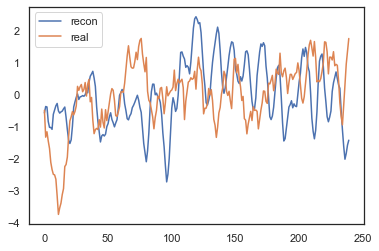

In [30]:
sns.set_theme(style='white')
f,ax = plt.subplots()

test = 13

s1 = S[y == test].T
response1 = X[y == test].T
response1 = response1.transpose((0,-1,-2))

a = model.predict(s1[:, :, np.newaxis])
ax.plot(zscore(a.mean(axis=(1, 2))),label='recon')
ax.plot(zscore(response1.mean(axis=(1,2))),label='real')
plt.legend()

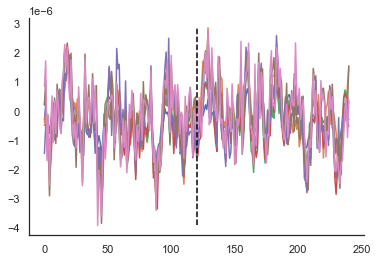

In [13]:
f, ax = plt.subplots()
sns.set_theme(style='white')
plt.plot(model.coef_.squeeze().T)
ax.vlines(x=int(0.5*240), ymin=model.coef_.min(),
          ymax=model.coef_.max(), colors='black', linestyles='dashed')
sns.despine()

# Boosting

In [11]:
from eelbrain import *

X_ = X[:160]
S_ = S[:160]

srate = 240
time = UTS(0, 1/srate, X_.shape[-1])
sensor = Sensor.from_montage('biosemi128')[:X.shape[1]]
eeg = NDVar(X_, (Case, sensor,time),name='EEG', info={'unit': 'µV'})
wn = NDVar(S_, (Case, time), name='STI', info={'unit': 'µV'})

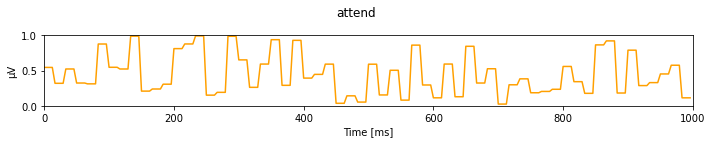

In [19]:
p = plot.UTS([[wn[0]]], xlim=1, w=10, h=2,title='attend')

Fitting models:   0%|          | 0/28 [00:00<?, ?it/s]

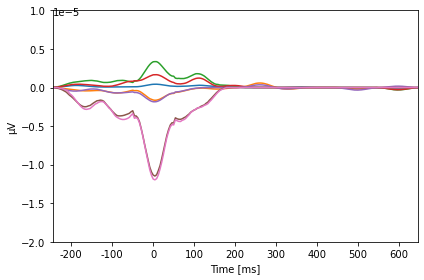

In [36]:
tmin = -.2
tmax = 0.6
encoder = boosting(eeg, wn, tmin, tmax,basis=0.1, scale_data=True,partitions=4)
fig = plot.Butterfly([encoder.h_scaled], w=6, h=4)

In [44]:
x = convolve(encoder.h_scaled, wn[0])
p = plot.UTS([[x]], xlim=1, w=10, h=2, title='attend')

ValueError: y=<NDVar 'STI': 7 sensor, 240 time> is ambiguous for required dimensions (None,)